In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications.mobilenet import preprocess_input

import matplotlib.pyplot as plt
%matplotlib inline

from mobilenet import get_mobilenet

Using TensorFlow backend.


In [4]:
data_dir = '/home/dongsung/study/machine_learning/distillation/data'

In [5]:
data_generator = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

train_generator = data_generator.flow_from_directory(
    data_dir + 'train', 
    target_size=(224, 224),
    batch_size=64
)

val_generator = data_generator.flow_from_directory(
    data_dir + 'val', shuffle=False,
    target_size=(224, 224),
    batch_size=64
)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


# Model

In [6]:
model = get_mobilenet(224, alpha=0.25, weight_decay=1e-5, dropout=0.1)
model.count_params()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 8)       216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 8)       32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 8)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 8)       72        
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 8)       32        
__________

In [12]:
from keras.applications.mobilenet import MobileNet

input_shape = (224, 224, 3)
model2 = MobileNet(
        include_top=True, weights='imagenet', 
        input_shape=input_shape, alpha=0.25)
model2.count_params()

model2.summary()

2113536/2108140 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 8)       216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 8)       32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 8)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 8)       72        
_________________________________________________________________
conv_dw_1_bn 

# Training

In [7]:
model.compile(
    optimizer=optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True), 
    loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy']
)

In [8]:
model.fit_generator(
    train_generator, 
    steps_per_epoch=400, epochs=30, verbose=1,
    callbacks=[
        ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=2, epsilon=0.007),
        EarlyStopping(monitor='val_acc', patience=4, min_delta=0.01)
    ],
    validation_data=val_generator, validation_steps=80, workers=4
)

/home/dongsung/tensorflow_virtualenv/lib/python3.5/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/30


ZeroDivisionError: integer division or modulo by zero

# Loss/epoch plots

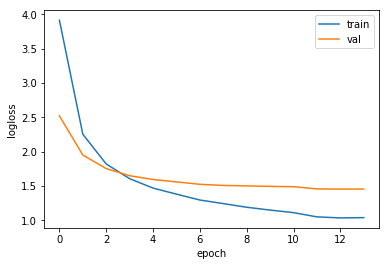

In [8]:
plt.plot(model.history.history['loss'], label='train');
plt.plot(model.history.history['val_loss'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('logloss');

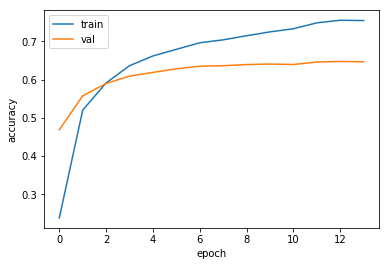

In [9]:
plt.plot(model.history.history['acc'], label='train');
plt.plot(model.history.history['val_acc'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

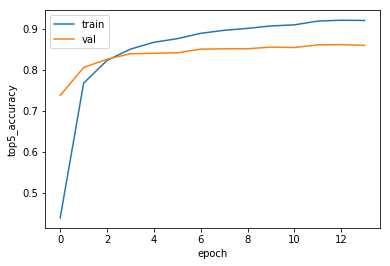

In [10]:
plt.plot(model.history.history['top_k_categorical_accuracy'], label='train');
plt.plot(model.history.history['val_top_k_categorical_accuracy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Results

In [11]:
model.evaluate_generator(val_generator, 80)

[1.4546428885310889, 0.646484375, 0.859375]